In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
pwd

'/content/yolov5-transfer-learning'

In [20]:
!pip install openimages

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 107.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 11.0 MB/s eta 0:00:00


In [28]:
!oi_download_dataset --base_dir download --csv_dir download --labels Cat Dog --format darknet --limit 500

2023-05-29  06:25:53 INFO Downloading 500 train images for class 'cat'
100% 500/500 [00:08<00:00, 61.01it/s]
2023-05-29  06:26:02 INFO Creating 500 train annotations (darknet) for class 'cat'
100% 500/500 [00:00<00:00, 2961.59it/s]
2023-05-29  06:26:02 INFO Downloading 500 train images for class 'dog'
 97% 485/500 [00:08<00:00, 69.66it/s]2023-05-29  06:26:11 WARNING Connection pool is full, discarding connection: open-images-dataset.s3.amazonaws.com. Connection pool size: 10
100% 500/500 [00:09<00:00, 54.58it/s]
2023-05-29  06:26:11 INFO Creating 500 train annotations (darknet) for class 'dog'
100% 500/500 [00:00<00:00, 2572.72it/s]


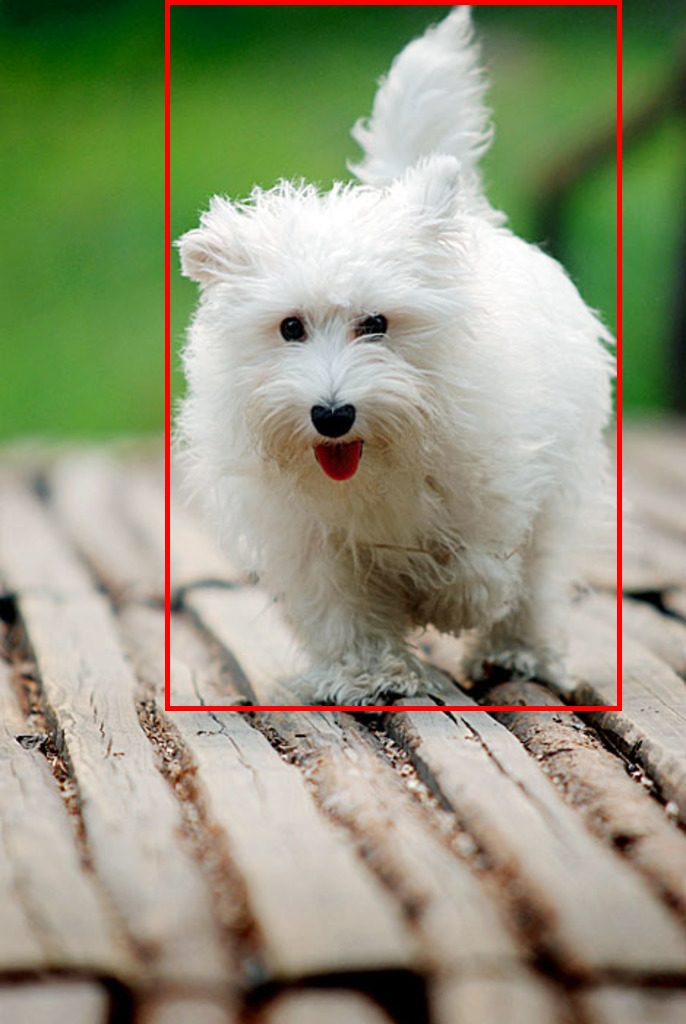

In [33]:
from PIL import Image, ImageDraw

def show_bbox(image_path):
    # convert image path to label path
    label_path = image_path.replace('/images/', '/darknet/')
    label_path = label_path.replace('.jpg', '.txt')

    # Open the image and create ImageDraw object for drawing
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)

    with open(label_path, 'r') as f:
        for line in f.readlines():
            # Split the line into five values
            label, x, y, w, h = line.split(' ')

            # Convert string into float
            x = float(x)
            y = float(y)
            w = float(w)
            h = float(h)

            # Convert center position, width, height into
            # top-left and bottom-right coordinates
            W, H = image.size
            x1 = (x - w/2) * W
            y1 = (y - h/2) * H
            x2 = (x + w/2) * W
            y2 = (y + h/2) * H

            # Draw the bounding box with red lines
            draw.rectangle((x1, y1, x2, y2),
                           outline=(255, 0, 0), # Red in RGB
                           width=5)             # Line width
    image.show()
    

show_bbox('/content/yolov5-transfer-learning/download/dog/images/00064d23bf997652.jpg')

In [34]:
import os

# Create a folder structure for YOLOv5 training
if not os.path.exists('data'):
    for folder in ['images', 'labels']:
        for split in ['train', 'val', 'test']:
            os.makedirs(f'data/{folder}/{split}')

In [35]:
import glob

def get_filenames(folder):
    filenames = set()
    
    for path in glob.glob(os.path.join(folder, '*.jpg')):
        # Extract the filename
        filename = os.path.split(path)[-1]        
        filenames.add(filename)

    return filenames


# Dog and cat image filename sets
dog_images = get_filenames('download/dog/images')
cat_images = get_filenames('download/cat/images')

In [36]:
# Check for duplicates
duplicates = dog_images & cat_images

print(duplicates)

{'0dcd8cc4b35a93b4.jpg', '1417eccd5854e04a.jpg', '0838125199f2caa7.jpg'}


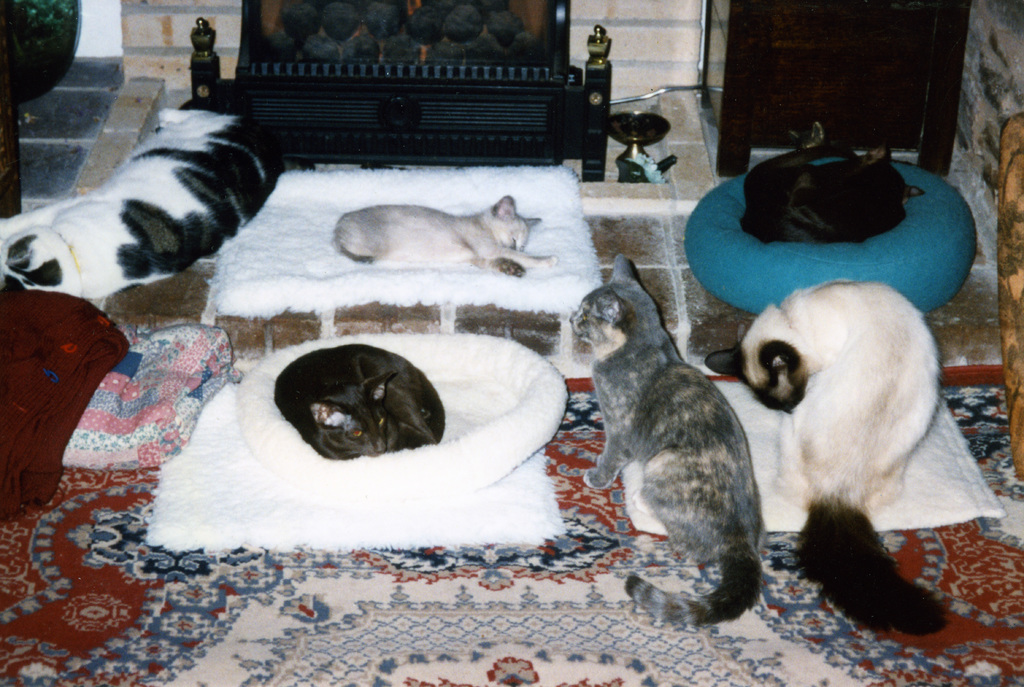

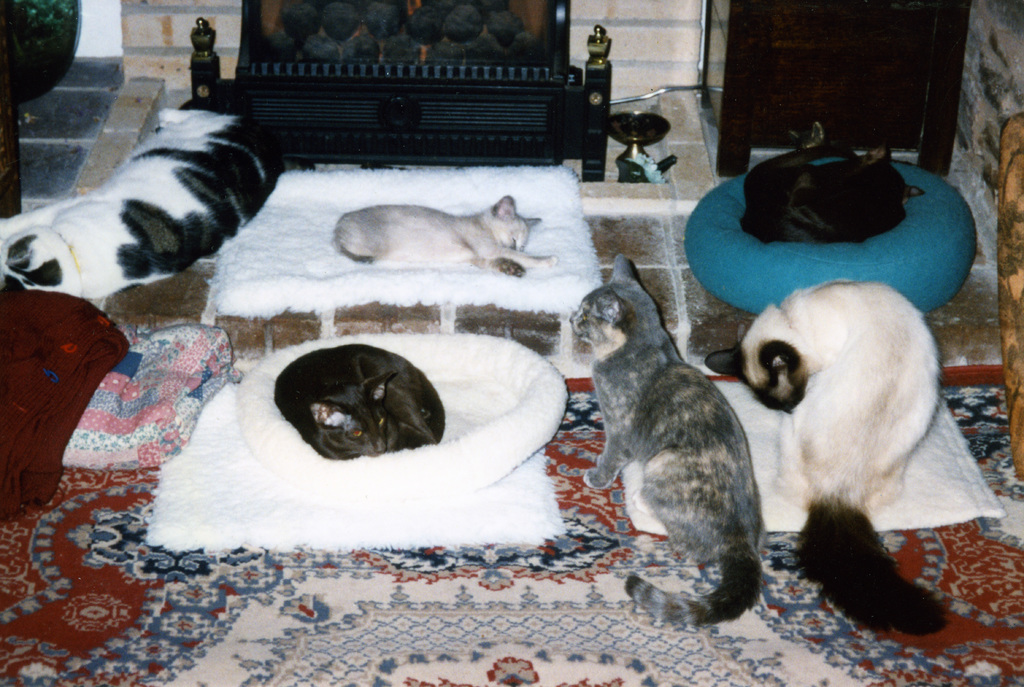

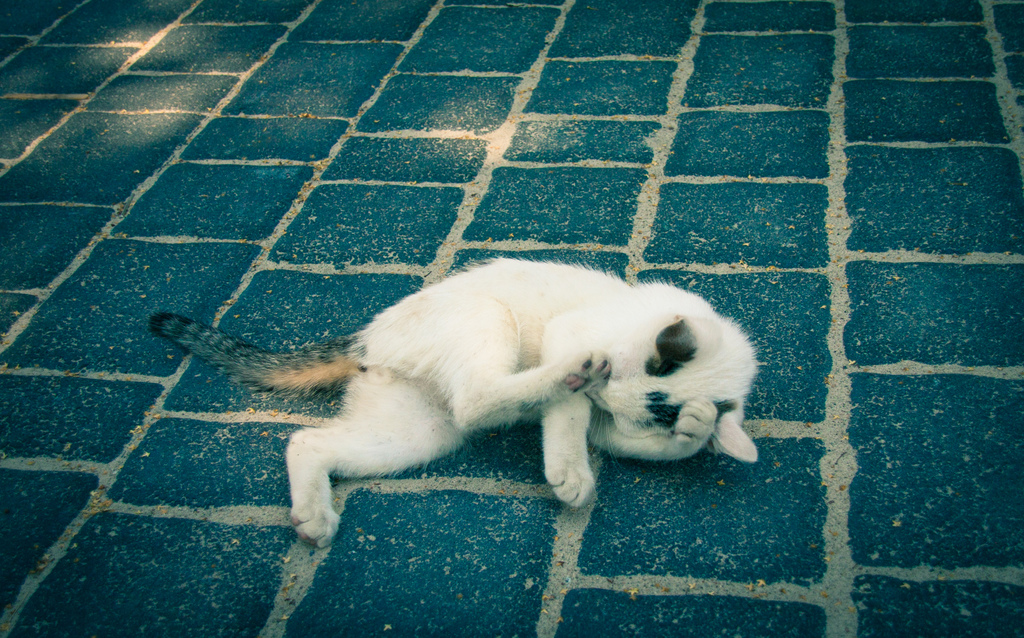

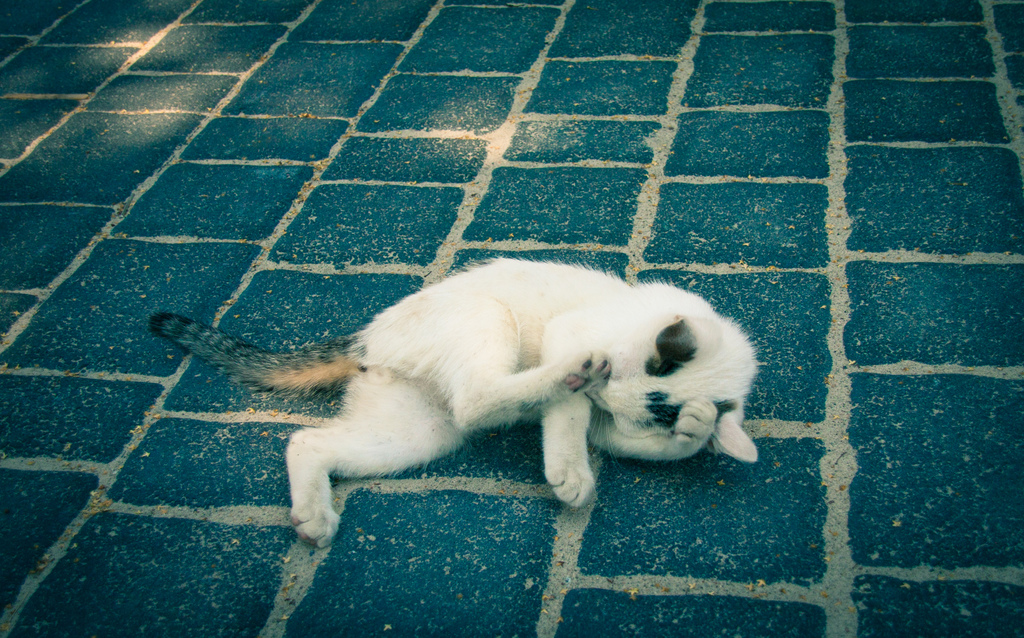

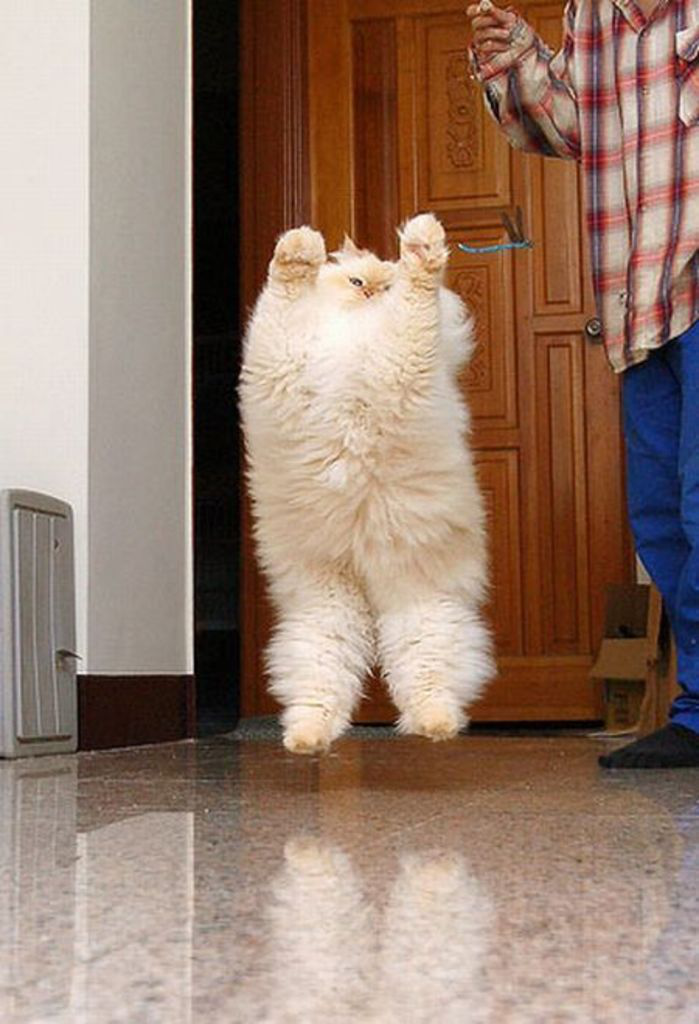

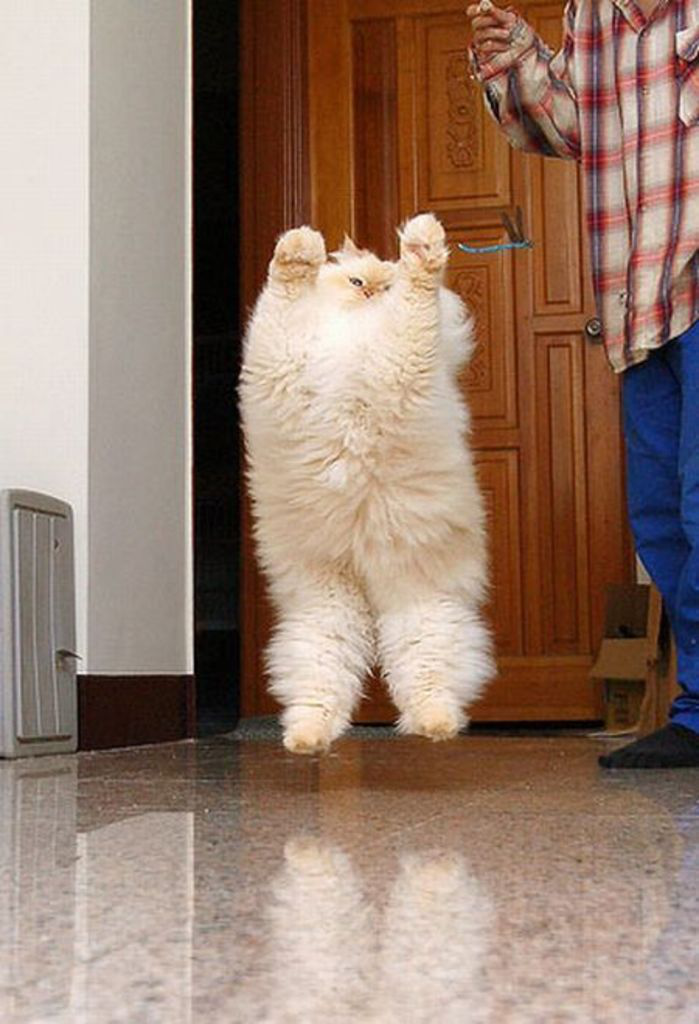

In [37]:
from PIL import Image

# Show the images from the duplicated filenames
for file in duplicates:
    for animal in ['cat', 'dog']:
        Image.open(f'download/{animal}/images/{file}').show()

In [38]:
dog_images -= duplicates

print(len(dog_images))

497


In [39]:
import numpy as np

dog_images = np.array(list(dog_images))
cat_images = np.array(list(cat_images))

# Use the same random seed for reproducability
np.random.seed(42)
np.random.shuffle(dog_images)
np.random.shuffle(cat_images)

In [40]:
import shutil

def split_dataset(animal, image_names, train_size, val_size):
    for i, image_name in enumerate(image_names):
        # Label filename
        label_name = image_name.replace('.jpg', '.txt')
        
        # Split into train, val, or test
        if i < train_size:
            split = 'train'
        elif i < train_size + val_size:
            split = 'val'
        else:
            split = 'test'
        
        # Source paths
        source_image_path = f'download/{animal}/images/{image_name}'
        source_label_path = f'download/{animal}/darknet/{label_name}'

        # Destination paths
        target_image_folder = f'data/images/{split}'
        target_label_folder = f'data/labels/{split}'

        # Copy files
        shutil.copy(source_image_path, target_image_folder)
        shutil.copy(source_label_path, target_label_folder)

# Cat data
split_dataset('cat', cat_images, train_size=400, val_size=50)

# Dog data (reduce the number by 1 for each set due to three duplicates)
split_dataset('dog', dog_images, train_size=399, val_size=49) 

In [42]:
!git clone https://github.com/ultralytics/yolov5

!pip install -U -r yolov5/requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 15705, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 15705 (delta 9), reused 15 (delta 3), pack-reused 15672
Receiving objects: 100% (15705/15705), 14.51 MiB | 19.75 MiB/s, done.
Resolving deltas: 100% (10750/10750), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 85.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 97.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 592.7/592.7 kB 52.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 125.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 83.6 MB/s eta 0

In [47]:
!python yolov5/train.py --data yolov5-transfer-learningcats_and_dogs.yaml --weights yolov5s.pt --epochs 30 --batch 4 --freeze 10

train: weights=yolov5s.pt, cfg=, data=yolov5-transfer-learningcats_and_dogs.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=30, batch_size=4, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[10], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-172-gc3c1304 Python-3.10.11 torch-2.0.1+cu118 CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, h